### Lets talk about streaming

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash', temperature = 0, google_api_key = GOOGLE_API_KEY)

/opt/anaconda3/envs/langchainAcademy/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [14]:
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated
from langchain_core.messages import RemoveMessage

class MessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]
    summary: str

In [15]:
def chat_model(state: MessagesState):
    summary = state['summary']
    if summary:
        system_message = f'''  Summary of conversation earlier: {summary}'''
        messages = [SystemState(content = system_message)] + state['messages']
    else:
        messages = state['messages']

    return {'messages': llm.invoke(messages)}

def summarize_conversation(state: MessagesState):
    summary = state['summary']
    if summary:
        summary_message = (
            f" This is the summary of the conversation to date: {summary}\n\n"
            " Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"
    messages = state['messages'] + [HumanMessage(content = summary_message)]
    summarization = llm.invoke(messages)
    removed_messages = [RemoveMessage(id = m.id) for m in state['messages'][:-3]]
    return {'messages': removed_messages, 'summary': summarization.content}

def condition(state: MessagesState):
    messages = state['messages']
    if len(messages)>6:
        # we will summarize now
        return 'summarize'

    else:
        return END

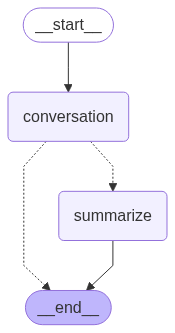

In [16]:

workflow = StateGraph(MessagesState)
workflow.add_node('conversation', chat_model)
workflow.add_node('summarize', summarize_conversation)

workflow.add_edge(START, 'conversation')
workflow.add_conditional_edges('conversation',
  condition,
  path_map={'summarize': 'summarize', '__end__': '__end__'})
workflow.add_edge('summarize', END)

memory = MemorySaver()

graph = workflow.compile(checkpointer = memory)
graph

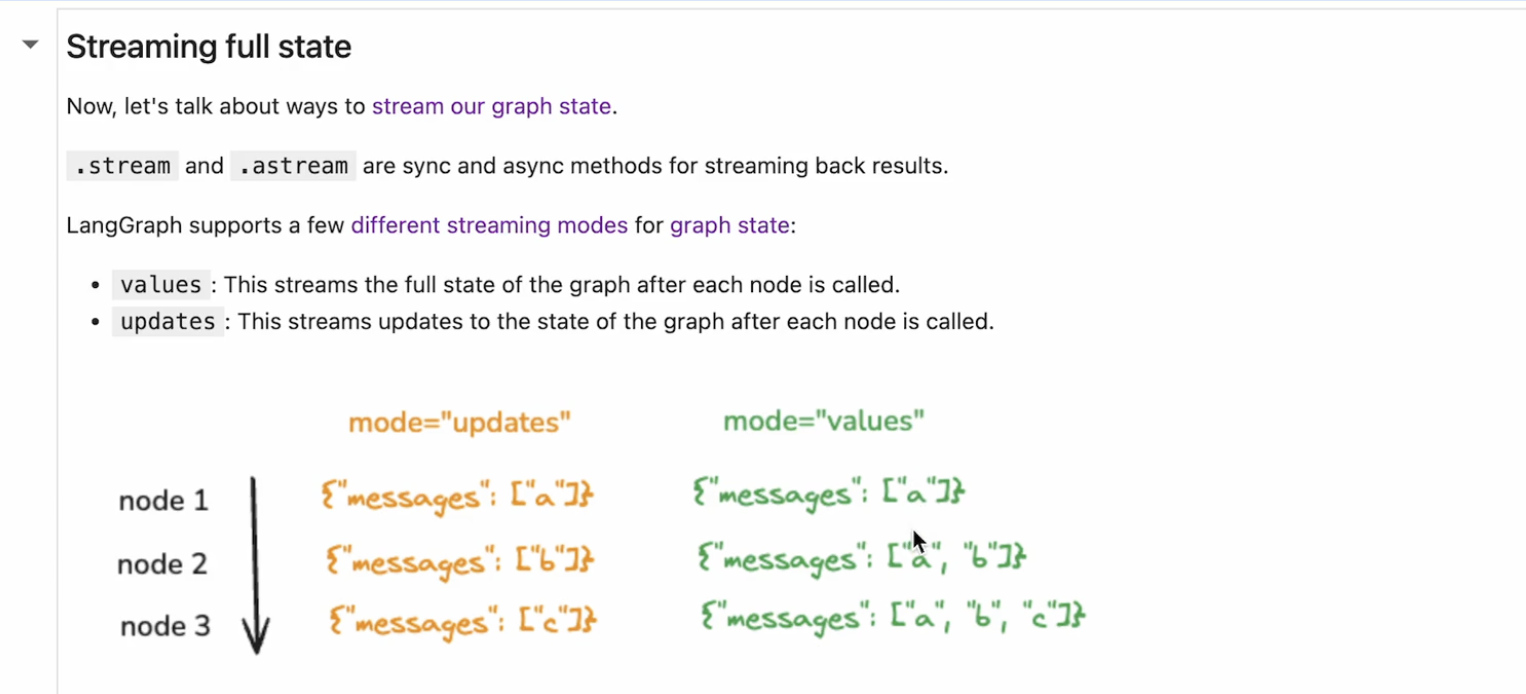

In [17]:
from langchain_core.messages import HumanMessage, AnyMessage, SystemMessage
config = {'configurable': {'thread_id': 1}}

for chunk in graph.stream({'messages': [HumanMessage(content='Hi this is Utkarsh')], 'summary': ''}, config, stream_mode='updates'):
    print(chunk)

{'conversation': {'messages': AIMessage(content="Hi Utkarsh! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--e1097d37-c97f-49a8-a631-4a367499dafa-0', usage_metadata={'input_tokens': 6, 'output_tokens': 21, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}})}}


In [20]:
config = {'configurable': {'thread_id': 2}}

for chunk in graph.stream({'messages': [HumanMessage(content='Hi this is Utkarsh')], 'summary': ''}, config, stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi this is Utkarsh', additional_kwargs={}, response_metadata={}, id='7dcc7351-8280-491d-965b-36defc5180f5'), AIMessage(content="Hi Utkarsh! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--5ad1f523-98cf-4c80-afc5-b53b3fea5cd0-0', usage_metadata={'input_tokens': 6, 'output_tokens': 21, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Hi this is Utkarsh', additional_kwargs={}, response_metadata={}, id='7d0cfdcd-b151-4827-86fc-19c71022bfa9')], 'summary': ''}
{'messages': [HumanMessage(content='Hi this is Utkarsh', additional_kwargs={}, response_metadata={}, id='7dcc7351-8280-491d-965b-36defc5180f5'), AIMessage(content="Hi Utkarsh! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'pr

#### LETS TALK ABOUT STREAMING TOKENS

We want to stream tokens the moment they are generated in the llm calls. Currently we are streaming the output of each graph nodes but not token level streaming

In [21]:
config = {'configurable': {'thread_id': 3}}

input_message = [HumanMessage(content = 'Tell me about the 49ers NFL team')]

async for event in graph.astream_events({'messages': input_message, 'summary':''}, config, version = 'v2'):
    print(event)
    print()

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team', additional_kwargs={}, response_metadata={})], 'summary': ''}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'c0bafb62-e7e4-4215-bb69-9b21a6223e6c', 'metadata': {'thread_id': 3}, 'parent_ids': []}

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me about the 49ers NFL team', additional_kwargs={}, response_metadata={}, id='f2b63cbb-69c1-4486-af48-e032e9599d82')], 'summary': ''}}, 'name': 'conversation', 'tags': ['graph:step:1'], 'run_id': 'd1145bdc-f5e4-44c1-9728-cd280adfdc3a', 'metadata': {'thread_id': 3, 'langgraph_step': 1, 'langgraph_node': 'conversation', 'langgraph_triggers': ('branch:to:conversation',), 'langgraph_path': ('__pregel_pull', 'conversation'), 'langgraph_checkpoint_ns': 'conversation:6c4b61af-68aa-5e56-12b1-aa9e0dc7c7b4'}, 'parent_ids': ['c0bafb62-e7e4-4215-bb69-9b21a6223e6c']}

{'event': 'on_chat_model_start', 'data'